In [1]:
from matplotlib import pyplot as plt

from dataset import get_dataset_class_number, get_num_samples
from utils import *

plt.style.use(['science', 'grid'])
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 11})


In [2]:
def read_data(data_path, method, ghost_dataset=None):
    results = []
    for name in os.listdir(data_path):
        path = os.path.join(data_path, name)
        if not os.path.isdir(path):
            continue
        if not os.path.isfile(os.path.join(path, 'results.json')):
            continue
        with open(os.path.join(path, 'results.json'), 'r') as f:
            res = json.load(f)
        with open(os.path.join(path, 'args.json'), 'r') as f:
            args = json.load(f)
        dic = res | args
        # dic['path'] = path
        results.append(dic)
    df = pd.DataFrame(results)
    # df = df.loc[(df['vf_bound'] != -inf)]
    df = df[['S_seed', 'seed', 'method', 'test_acc', 'num_samples', 'ghost_dataset_name']]
    if ghost_dataset is not None:
        df = df.loc[(df['S_seed'] < num_S_seeds) & (df['seed'] < num_seeds) & (df['method'] == method) & (
                df['ghost_dataset_name'] == ghost_dataset)]
    else:
        df = df.loc[(df['S_seed'] < num_S_seeds) & (df['seed'] < num_seeds) & (df['method'] == method) & (
            df['ghost_dataset_name'].isnull())]
    return df


def get_exp_res_dict(df):
    exp_res_dict = {k: 0 for k in num_samples}
    for ns in num_samples:
        df_exp = df.loc[(df['num_samples'] == ns)]
        df_exp['test_error'] = 100 - df_exp['test_acc']
        exp_res_dict[ns] = (df_exp['test_error'].mean(), df_exp['test_error'].std())
    return exp_res_dict


In [3]:
num_seeds = 5
num_S_seeds = 5
dataset = 'cifar10'
ghost_dataset = 'svhn'
ghost_dataset2 = 'cifar100'

data_path = f'<your data dir>/train_my_cnn.CNN_my_mlp.MLP_seed_5_5_nh3/{dataset}/'
num_classes = get_dataset_class_number(dataset)
num_samples = get_num_samples(dataset)

df0 = read_data(data_path, 'vanilla', None)
exp_res_dicts0 = get_exp_res_dict(df0)
df1 = read_data(data_path, 'rib', ghost_dataset)
exp_res_dicts1 = get_exp_res_dict(df1)
df2 = read_data(data_path, 'rib', None)
exp_res_dicts2 = get_exp_res_dict(df2)
df3 = read_data(f'<your data dir>/train_my_cnn.CNN_my_mlp.MLP_seed_5_5_nh3_plot/{dataset}/', 'rib',
                ghost_dataset2)
exp_res_dicts3 = get_exp_res_dict(df3)


/tmp/ipykernel_1081689/1803961574.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['test_error'] = 100 - df_exp['test_acc']


SGD&61.51{\scriptsize \textpm 1.13}&50.22{\scriptsize \textpm 0.81}&32.81{\scriptsize \textpm 0.70} \\
CIFAR10-SVHN&61.26{\scriptsize \textpm 1.20}&51.59{\scriptsize \textpm 0.97}&37.13{\scriptsize \textpm 0.94} \\
CIFAR10-CIFAR100&60.31{\scriptsize \textpm 0.91}&49.20{\scriptsize \textpm 0.78}&33.27{\scriptsize \textpm 0.61} \\
CIFAR10-CIFAR10&59.16{\scriptsize \textpm 1.17}&47.57{\scriptsize \textpm 0.60}&31.06{\scriptsize \textpm 0.38} \\


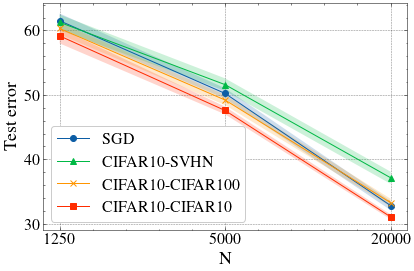

In [4]:
def plot_mean_std(ax, dic, label, marker):
    mean = np.array([dic[k][0] for k in num_samples])
    std = np.array([dic[k][1] for k in num_samples])
    ax.plot(range(len(num_samples)), mean, label=label, marker=marker)
    ax.fill_between(range(len(num_samples)), mean - std, mean + std, alpha=0.2)
    print(f'{label}&', end='')
    print('&'.join('{:.2f}{{\\scriptsize \\textpm {:.2f}}}'.format(dic[k][0], dic[k][1]) for k in num_samples), end='')
    print(' \\\\')


fig, ax = plt.subplots(figsize=(6, 4))
plot_mean_std(ax, exp_res_dicts0, 'SGD', 'o')
plot_mean_std(ax, exp_res_dicts1, 'CIFAR10-SVHN', '^')
plot_mean_std(ax, exp_res_dicts3, 'CIFAR10-CIFAR100', 'x')
plot_mean_std(ax, exp_res_dicts2, 'CIFAR10-CIFAR10', 's')

ax.set_xlabel('N', size=18)
ax.set_ylabel('Test error', size=18)
ax.tick_params(labelsize=16)
ax.set_xticks(range(len(num_samples)))
ax.set_xticklabels(num_samples)
ax.legend(fontsize=16)
# ax.set_title(dataset)
fig.tight_layout()
fig.savefig(os.path.join(data_path + '../', f'{dataset}_vary_domain.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()
# print('=======================')
# print(f"{dataset:>10}\t", '\t'.join(str(s) for s in num_samples))
# for method in methods:
#     print(f"{method:>10}\t", '\t'.join(
#         '{:.2f}±{:.2f}'.format(exp_res_dicts[method][k][0], exp_res_dicts[method][k][1]) for k in num_samples))
# for ngs in num_ghost_samples:
#     print(f"rib (n={ngs})\t", '\t'.join('{:.2f}'.format(exp_res_dicts['rib'][k][ngs]) for k in samples))
